In [1]:
%load_ext autoreload
%autoreload 2

In [28]:
import run
import measure

import pickle
from scipy import stats
import numpy as np
import pandas as pd
import glob

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

#Supress default INFO logging

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

import sys
sys.path.append('../../')
sys.path.append('../')


import german.default as german_default
import german.questions as german_questions
import german.parameters as german_parameters
import german.valid as german_valid

import ipums.default as ipums_default
import ipums.valid as ipums_valid
import ipums.questions as ipums_questions
import ipums.parameters as ipums_parameters

In [131]:
predicate_strategy_mapping = {
    '1-way marginal': 1,
    '2-way marginal': 2,
    '3-way marginal': 3
}

df = []

for default, question in [
    (ipums_default.default, 'I1'), (german_default.default, 'G1')
]:
    default = {**run.DEFAULT, **default} 
    controls = []
    for k in [3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 50]:
        controls.append(
            [
                ('k', k)
            ]
        )
    for predicate_strategy in [
        '1-way marginal', '2-way marginal', '3-way marginal'
    ]:
        controls.append(
            [
                ('predicate_strategy', predicate_strategy)
            ]
        )
    for setting_change in controls:
        setting = default.copy()
        for key, value in setting_change: 
            setting[key] = value
        hashed = run.hash_setting(setting)
        fprefix = f'./intermediates/{hashed}'
        t_phase_2 = []
        t_phase_3_topk = []
        t_phase_3_influci = []
        t_phase_3_rankci = []
        t_phase_23 = []
        for fname in glob.glob(fprefix + '*'):
            with open(fname, 'rb') as finp:
                intermediates = pickle.load(finp)
            t_phase_2.append(intermediates['t_phase_2'])
            t_phase_3_topk.append(intermediates['t_phase_3_topk'])
            t_phase_3_influci.append(intermediates['t_phase_3_influci'])
            t_phase_3_rankci.append(intermediates['t_phase_3_rankci'])
            t_phase_23.append(intermediates['t_phase_2'] + intermediates['t_phase_3'])
        t_phase_2 = np.mean(t_phase_2)
        t_phase_3_topk = np.mean(t_phase_3_topk)
        t_phase_3_influci = np.mean(t_phase_3_influci)
        t_phase_3_rankci = np.mean(t_phase_3_rankci)
        t_phase_23 = np.mean(t_phase_23)
        df.append({
            'Question': question,
            'Explanation Runtime (s)': t_phase_23,
            'Explanation Size k': setting['k'],
            'Predicate Size l': predicate_strategy_mapping[
                setting['predicate_strategy']],
        })
#         print(f'{t_phase_2:.3f},\t {t_phase_3_topk:.0f},\t {t_phase_3_influci:.1f},\t {t_phase_3_rankci:.5f}')
#         print(t_phase_3_topk, t_phase_3_influci, t_phase_3_rankci)

In [132]:
df = pd.DataFrame(df)

In [133]:
sns.set(style='whitegrid', font_scale=1.2)

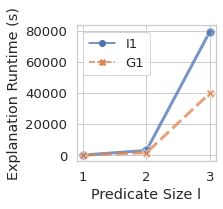

In [135]:
fig, ax = plt.subplots(figsize=(2.5,2.5))
sns.lineplot(data=df.query('`Explanation Size k` == 5'), 
             x='Predicate Size l', y='Explanation Runtime (s)', 
             hue='Question', 
             style='Question', 
             lw = 3,
             ax = ax,
             alpha = 0.75,
             markersize = 9,
             markers=True, 
             dashes=True)
ax.legend(ncol=1)#, loc=(-0.5, 1.05))
ax.xaxis.set_major_locator(mtick.MaxNLocator(integer=True))
# ax.set_xscale('log')
# ax.set_ylim(0, 1)
fig.savefig(f'./plots/Runtime-l.pdf', bbox_inches='tight')

In [138]:
df.query('`Explanation Size k`==5')['Explanation Runtime (s)']

2        67.269939
11       67.269939
12     3078.210784
13    79633.983841
16       40.718584
25       40.718584
26     1586.738724
27    39921.984256
Name: Explanation Runtime (s), dtype: float64

In [151]:
predicate_strategy_mapping = {
    '1-way marginal': 1,
    '2-way marginal': 2,
    '3-way marginal': 3
}

kdf = []

for default, dataset, qprefix, questions in zip(
    [ipums_default.default, german_default.default], 
    ['IPUMS', 'German'],
    ['I', 'G'],
    [ipums_valid.questions, german_valid.questions],
):
    for i, question in enumerate(questions):
        default = {**run.DEFAULT, **default}
        controls = []
        for k in [3, 4, 5, 6, 7, 8, 9, 10, 15, 20]:
            controls.append(question + 
                [
                    ('k', k)
                ]
            )
        for setting_change in controls:
            setting = default.copy()
            for key, value in setting_change: 
                setting[key] = value
            hashed = run.hash_setting(setting)
            fprefix = f'./intermediates/{hashed}'
            t_phase_2 = []
            t_phase_3_topk = []
            t_phase_3_influci = []
            t_phase_3_rankci = []
            t_phase_23 = []
            for fname in glob.glob(fprefix + '*'):
                with open(fname, 'rb') as finp:
                    intermediates = pickle.load(finp)
                t_phase_2.append(intermediates['t_phase_2'])
                t_phase_3_topk.append(intermediates['t_phase_3_topk'])
                t_phase_3_influci.append(intermediates['t_phase_3_influci'])
                t_phase_3_rankci.append(intermediates['t_phase_3_rankci'])
                t_phase_23.append(intermediates['t_phase_2'] + intermediates['t_phase_3'])
            t_phase_2 = np.mean(t_phase_2)
            t_phase_3_topk = np.mean(t_phase_3_topk)
            t_phase_3_influci = np.mean(t_phase_3_influci)
            t_phase_3_rankci = np.mean(t_phase_3_rankci)
            t_phase_23 = np.mean(t_phase_23)
            kdf.append({
                'Question': f'{qprefix}{i+1}',
                'NoiseQuant': t_phase_2,
                'Topk': t_phase_3_topk,
                'InfluCI': t_phase_3_influci,
                'RankCI':  t_phase_3_rankci,
                'Explanation Runtime (s)': t_phase_23,
                'Explanation Size k': setting['k'],
                'Predicate Size l': predicate_strategy_mapping[
                    setting['predicate_strategy']],
            })
#         print(f'{t_phase_2:.3f},\t {t_phase_3_topk:.0f},\t {t_phase_3_influci:.1f},\t {t_phase_3_rankci:.5f}')
#         print(t_phase_3_topk, t_phase_3_influci, t_phase_3_rankci)
kdf = pd.DataFrame(kdf)

In [152]:
kdf

,Question,NoiseQuant,Topk,InfluCI,RankCI,Explanation Runtime (s),Explanation Size k,Predicate Size l
0,I1,0.002591,62.579145,2.760654,0.000696,65.343086,3,1
1,I1,0.002478,62.772776,3.627100,0.000825,66.403179,4,1
2,I1,0.002495,61.241250,4.236319,0.000923,65.480987,5,1
3,I1,0.002504,62.539953,5.410714,0.001251,67.954422,6,1
4,I1,0.002475,62.597818,6.338682,0.001144,68.940119,7,1
...,...,...,...,...,...,...,...,...
95,G5,0.000968,28.156266,4.623864,0.001199,32.782297,8,1
96,G5,0.000953,28.336226,5.183753,0.001338,33.522270,9,1
97,G5,0.000956,28.240465,5.782035,0.001608,34.025064,10,1
98,G5,0.000998,28.609658,8.697027,0.001915,37.309597,15,1


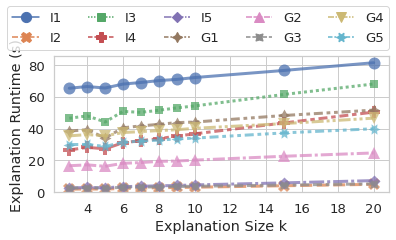

In [155]:
fig, ax = plt.subplots(figsize=(6,2.5))
sns.lineplot(data=kdf.query('`Predicate Size l` == 1'),
             x='Explanation Size k', y='Explanation Runtime (s)', 
             hue='Question', 
             style='Question', 
             lw = 3,
             ax = ax,
             alpha = 0.75,
             markersize = 12,
             markeredgewidth = 0,
             markers=True, 
             dashes=True)
ax.legend(ncol=5, loc=(-0.14, 1.05),markerscale=1.7)
ax.xaxis.set_major_locator(mtick.MaxNLocator(integer=True))
# ax.legend(ncol=2, loc=(0.05, 1.05))
# ax.legend(ncol=1)
# ax.set_xscale('log')
ax.set_ylim(0, None)
fig.savefig(f'./plots/Runtime-k.pdf', bbox_inches='tight')

In [148]:
kdf.query('`Explanation Size k` == 5').mean()

NoiseQuant                  0.005810
Topk                       27.973052
InfluCI                     3.811788
RankCI                      0.001045
Explanation Runtime (s)    31.791694
Explanation Size k          5.000000
Predicate Size l            1.000000
dtype: float64

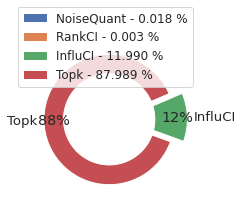

In [150]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['NoiseQuant', 'RankCI', 'InfluCI', 'Topk']
# y = np.array([0.002, 0.00093,  4.5, 63])  # IPUMS default
# y = np.array([0.005810, 0.001045,  3.811788, 27.973052])  # Average over all
runtime = kdf.query('`Explanation Size k` == 5').mean()
y = np.array([runtime[label] for label in labels]) # Average over all
porcent = 100.*y/y.sum()
explode = (0.1, 0.1, 0.1, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots(figsize=(3,3))
def autopct_more_than_1(pct):
    return ('%1.f%%' % pct) if pct > 1 else ''
patches, texts, _ = ax1.pie(y, labels=['', '', 'InfluCI', 'Topk'], 
                            explode=explode, startangle=-20, pctdistance=0.85,
                           autopct = autopct_more_than_1)
# ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
labels = ['{0} - {1:1.3f} %'.format(i,j) for i,j in zip(labels, porcent)]
ax1.legend(patches, labels, loc=(10, -10), bbox_to_anchor=(-0.1, 0.7), fontsize=12)

# draw circle
centre_circle = plt.Circle((-0.1, 0), 0.70, fc='white')
fig = plt.gcf()
  
# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)

# plt.show()

plt.savefig('./plots/Runtime-breakdown.pdf', bbox_inches='tight')

In [35]:
df

,dataset,Explanation Runtime (s),Explanation Size k,Predicate Size l
0,IPUMS,65.343086,3,1
1,IPUMS,66.403179,4,1
2,IPUMS,67.269939,5,1
3,IPUMS,67.954422,6,1
4,IPUMS,68.940119,7,1
5,IPUMS,70.149645,8,1
6,IPUMS,70.874884,9,1
7,IPUMS,72.046439,10,1
8,IPUMS,76.519916,15,1
9,IPUMS,81.360851,20,1


In [84]:
default = german_default.default
for default in [ipums_default.default, german_default.default]:
    default = {**run.DEFAULT, **default} 
    controls = []
    for k in [3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 50]:
        controls += [
            [
                ('k', k)
            ]
        ]
    for setting_change in controls:
        setting = default.copy()
        for key, value in setting_change: 
            setting[key] = value
        hashed = run.hash_setting(setting)
        fprefix = f'./intermediates/{hashed}'
        t_phase_2 = []
        t_phase_3_topk = []
        t_phase_3_influci = []
        t_phase_3_rankci = []
        for fname in glob.glob(fprefix + '*'):
            with open(fname, 'rb') as finp:
                intermediates = pickle.load(finp)
            t_phase_2.append(intermediates['t_phase_2'])
            t_phase_3_topk.append(intermediates['t_phase_3_topk'])
            t_phase_3_influci.append(intermediates['t_phase_3_influci'])
            t_phase_3_rankci.append(intermediates['t_phase_3_rankci'])
        t_phase_2 = np.mean(t_phase_2)
        t_phase_3_topk = np.mean(t_phase_3_topk)
        t_phase_3_influci = np.mean(t_phase_3_influci)
        t_phase_3_rankci = np.mean(t_phase_3_rankci)
        print(f'{t_phase_2:.3f},\t {t_phase_3_topk:.0f},\t {t_phase_3_influci:.1f},\t {t_phase_3_rankci:.5f}')
#         print(t_phase_3_topk, t_phase_3_influci, t_phase_3_rankci)

0.003,	 63,	 2.8,	 0.00070
0.002,	 63,	 3.6,	 0.00082
0.002,	 63,	 4.5,	 0.00093
0.003,	 63,	 5.4,	 0.00125
0.002,	 63,	 6.3,	 0.00114
0.003,	 63,	 7.2,	 0.00128
0.002,	 63,	 8.2,	 0.00138
0.002,	 63,	 9.2,	 0.00148
0.002,	 63,	 13.9,	 0.00204
0.003,	 63,	 18.7,	 0.00255
0.002,	 63,	 47.5,	 0.00572
0.001,	 36,	 2.2,	 0.00098
0.001,	 36,	 2.9,	 0.00105
0.001,	 37,	 3.7,	 0.00107
0.001,	 36,	 4.5,	 0.00175
0.001,	 36,	 5.3,	 0.00143
0.001,	 37,	 6.1,	 0.00130
0.001,	 37,	 7.0,	 0.00161
0.001,	 36,	 7.7,	 0.00151
0.001,	 36,	 11.8,	 0.00217
0.001,	 37,	 15.0,	 0.00264
0.001,	 34,	 38.0,	 0.00537


In [ ]:
predicate_strategy_mapping = {
    '1-way marginal': 1,
    '2-way marginal': 2,
    '3-way marginal': 3
}

df = []

for default, dataset, qprefix, questions in zip(
    [ipums_default.default, german_default.default], 
    ['IPUMS', 'German'],
    ['I', 'G'],
    [ipums_valid.questions, german_valid.questions],
):
    default = {**run.DEFAULT, **default} 
    for i, question in enumerate(questions):
        controls = []
        for k in [3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 50]:
            controls.append( question + 
                [
                    ('k', k)
                ]
            )
#         for predicate_strategy in [
#             '2-way marginal', '3-way marginal'
#         ]:
#             controls.append(
#                 [
#                     ('predicate_strategy', predicate_strategy)
#                 ]
#             )
        for setting_change in controls:
            setting = default.copy()
            for key, value in setting_change: 
                setting[key] = value
            hashed = run.hash_setting(setting)
            fprefix = f'./intermediates/{hashed}'
            t_phase_2 = []
            t_phase_3_topk = []
            t_phase_3_influci = []
            t_phase_3_rankci = []
            t_phase_23 = []
            if len(glob.glob(fprefix + '*')) == 0:
                continue
            for fname in glob.glob(fprefix + '*'):
                with open(fname, 'rb') as finp:
                    intermediates = pickle.load(finp)
                t_phase_2.append(intermediates['t_phase_2'])
                t_phase_3_topk.append(intermediates['t_phase_3_topk'])
                t_phase_3_influci.append(intermediates['t_phase_3_influci'])
                t_phase_3_rankci.append(intermediates['t_phase_3_rankci'])
                t_phase_23.append(intermediates['t_phase_2'] + intermediates['t_phase_3'])
            t_phase_2 = np.mean(t_phase_2)
            t_phase_3_topk = np.mean(t_phase_3_topk)
            t_phase_3_influci = np.mean(t_phase_3_influci)
            t_phase_3_rankci = np.mean(t_phase_3_rankci)
            t_phase_23 = np.mean(t_phase_23)
            df.append({
                'Question': f'{qprefix}{i+1}',
                'Explanation Runtime (s)': t_phase_23,
                'Explanation Size k': setting['k'],
                'Predicate Size l': predicate_strategy_mapping[
                    setting['predicate_strategy']],
            })
#             print(f'{qprefix}{i+1}', setting['k'])
    #         print(f'{t_phase_2:.3f},\t {t_phase_3_topk:.0f},\t {t_phase_3_influci:.1f},\t {t_phase_3_rankci:.5f}')
    #         print(t_phase_3_topk, t_phase_3_influci, t_phase_3_rankci)